# Task 4: Neo4j

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from neo4j import GraphDatabase  
from de_classes.neo4j_classes.utils_neo4j import UtilsNeo4j 
from de_classes.neo4j_classes.neo4j_query import Neo4jQuery
from de_classes.utility_classes.spark_manager import SparkManager
load_dotenv()

True

In [2]:
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = UtilsNeo4j(
    NEO4J_URI, 
    NEO4J_USERNAME,
    NEO4J_PASSWORD)

Successfully connected to Neo4j.


## Ingest Data

In [3]:
path = [
    ("Co2", os.getenv("CLEANED_CO2")),
    ("Weather", os.getenv("CLEANED_WEATHER")),
    ("Country", os.getenv("COUNTRY_CSV")),
    ("City", os.getenv("CITY_CSV"))
]

with SparkManager(app_name = "Neo4j App") as manager:
    neo_spark = manager.spark
    driver.ingest_all_from_list(neo_spark, path)

25/08/29 19:46:03 WARN Utils: Your hostname, fz.localdomain resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/29 19:46:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/29 19:46:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Connect Relationship

In [4]:
neo4j_query = Neo4jQuery(driver)
neo4j_query.create_relationships()

Linked City -> Country
Linked Country -> Co2
Linked City -> Weather
Created Weather -> ON_DATE -> Date
Linked CO2 -> Sector (EMIT_FROM)
Linked CO2 -> EmissionValue (HAS_VALUE)


## Query 1


=== Country-month aggregate ===


,Country,Month,Monthly Avg Temp (°C),Monthly Total CO₂
0,China,2021-12,6.22,2037.45
1,China,2022-01,1.84,1974.27
2,China,2022-02,1.04,2101.67
3,China,2022-03,11.15,2233.34
4,China,2022-04,15.81,2141.89
5,China,2022-05,18.14,2189.27
6,China,2022-06,23.24,2349.70
7,China,2022-07,26.64,2348.52
8,France,2021-12,5.94,160.66
9,France,2022-01,6.40,162.04


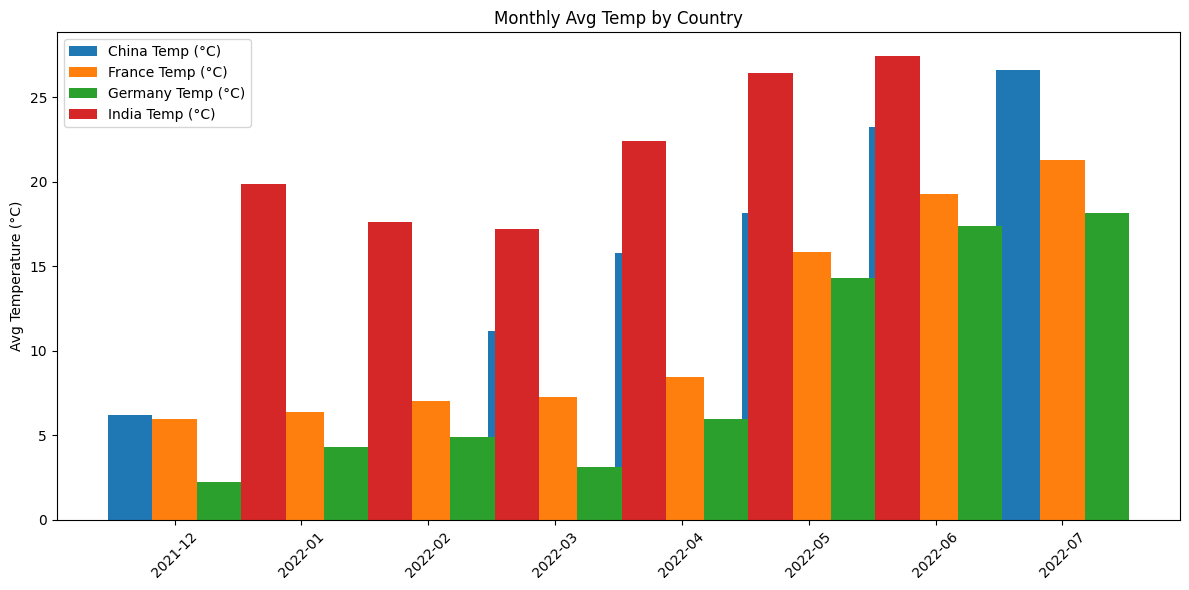

In [5]:
query1_results = neo4j_query.get_monthly_temp_and_co2(limit=30)
df = pd.DataFrame([
    {
        "Country": r["country"],
        "Month": r["month"],
        "Monthly Avg Temp (°C)": round(r["monthly_avg_temp"], 2),
        "Monthly Total CO₂": round(r["monthly_total_co2"], 2),
    }
    for r in query1_results
])

print("\n=== Country-month aggregate ===")
display(df.head(len(df))) 

if not df.empty:
    df_pivot = df.pivot(index="Month", columns="Country", values="Monthly Avg Temp (°C)")

    fig, ax1 = plt.subplots(figsize=(12, 6))
    width = 0.35
    months = range(len(df_pivot.index))

    for i, country in enumerate(df_pivot.columns):
        ax1.bar([m + i*width for m in months],
                df_pivot[country],
                width=width,
                label=f"{country} Temp (°C)")

    ax1.set_xticks([m + width for m in months])
    ax1.set_xticklabels(df_pivot.index, rotation=45)
    ax1.set_ylabel("Avg Temperature (°C)")
    ax1.set_title("Monthly Avg Temp by Country")
    ax1.legend()
    plt.tight_layout()
    plt.show()

## Query 2


=== Hot cities vs CO₂ ===


,City,Country,Hot Days Count,Avg CO₂ (MtCO₂/day)
0,Patna,India,81,0.89
1,Bhopal,India,79,0.89
2,Chandigarh,India,76,0.89
3,Daman,India,74,0.89
4,Phoenix,United States,73,1.33
5,Chennai,India,61,0.89
6,Kolkata,India,58,0.89
7,Lucknow,India,57,0.89
8,New Delhi,India,54,0.89
9,Pondicherry,India,52,0.89


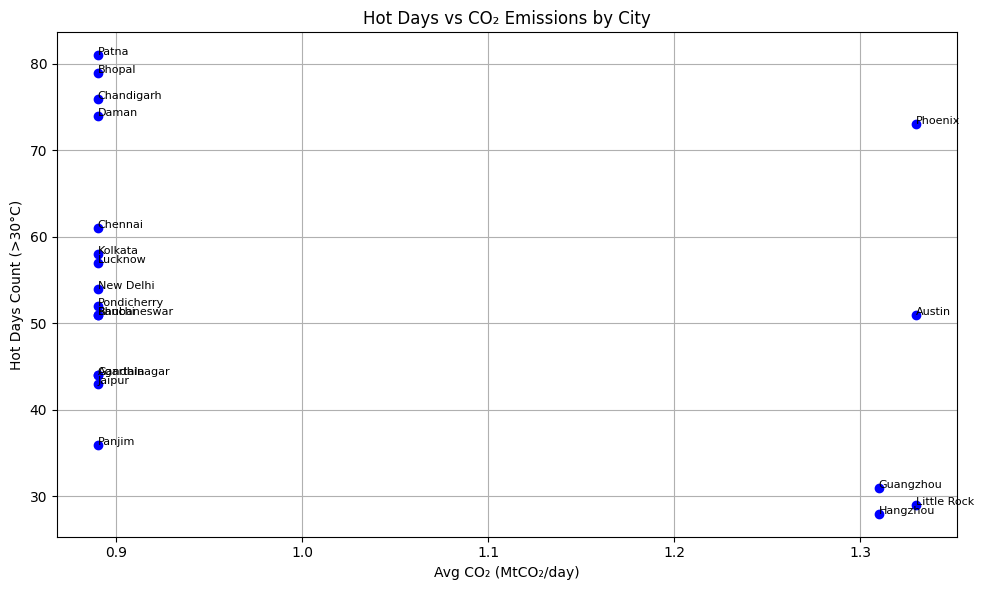

In [6]:
query2_results = neo4j_query.get_hot_cities_vs_co2(limit=20)

import pandas as pd
df = pd.DataFrame([
    {
        "City": r["city"],
        "Country": r["country"],
        "Hot Days Count": r["hot_days_count"],
        "Avg CO₂ (MtCO₂/day)": round(r["avg_co2"], 2)
    }
    for r in query2_results
])

print("\n=== Hot cities vs CO₂ ===")
display(df.head(len(df)))


if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.scatter(df["Avg CO₂ (MtCO₂/day)"], df["Hot Days Count"], c="blue")

    for i, row in df.iterrows():
        plt.text(row["Avg CO₂ (MtCO₂/day)"], row["Hot Days Count"], row["City"], fontsize=8)

    plt.xlabel("Avg CO₂ (MtCO₂/day)")
    plt.ylabel("Hot Days Count (>30°C)")
    plt.title("Hot Days vs CO₂ Emissions by City")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
neo4j_query.close()

Neo4j driver closed.
